<a href="https://colab.research.google.com/github/lusandagutswana/gutswanawebpage/blob/main/Transformers_task_Lusanda_masters_research_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

In [7]:
url = "https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv"
df = pd.read_csv(url)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [9]:
unique_labels = df['label'].unique()

In [10]:
print("Unique labels in dataset:", unique_labels)

Unique labels in dataset: [0 3 2 5 4 1]


In [11]:
df.isnull().sum

<bound method DataFrame.sum of         text  label  label_name
0      False  False       False
1      False  False       False
2      False  False       False
3      False  False       False
4      False  False       False
...      ...    ...         ...
15995  False  False       False
15996  False  False       False
15997  False  False       False
15998  False  False       False
15999  False  False       False

[16000 rows x 3 columns]>

In [12]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


Data analysis

In [13]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'frequence of classes')

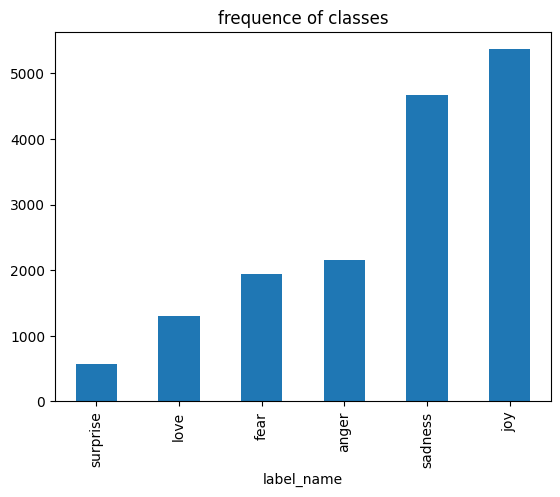

In [14]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.bar()
plt.title("frequence of classes")

<Axes: title={'center': 'Words per tweet'}, xlabel='label_name'>

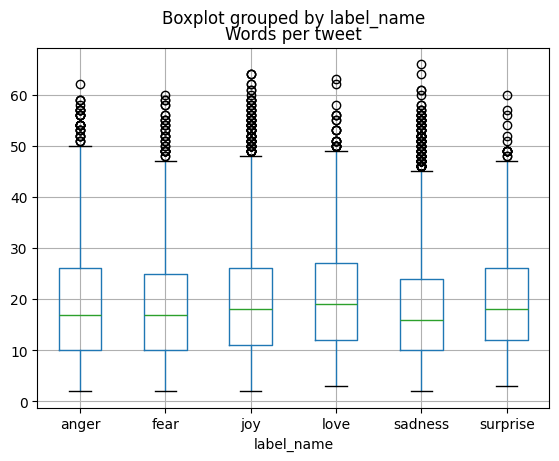

In [15]:
df['Words per tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name")

<Axes: ylabel='Words per tweet'>

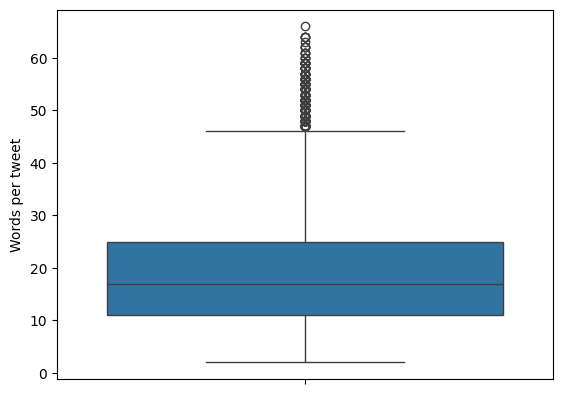

In [16]:
import seaborn as sns
sns.boxplot(df['Words per tweet'])

In [17]:
print(df.head())

                                                text  label label_name  \
0                            i didnt feel humiliated      0    sadness   
1  i can go from feeling so hopeless to so damned...      0    sadness   
2   im grabbing a minute to post i feel greedy wrong      3      anger   
3  i am ever feeling nostalgic about the fireplac...      2       love   
4                               i am feeling grouchy      3      anger   

   Words per tweet  
0                4  
1               21  
2               10  
3               18  
4                4  


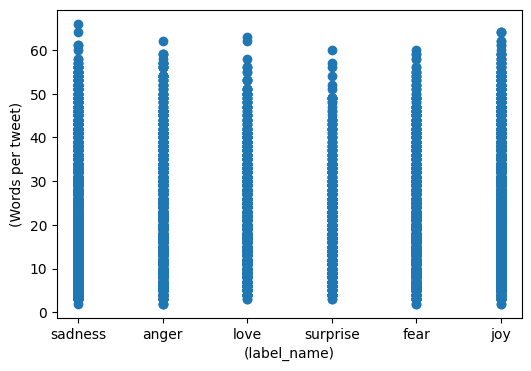

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df['label_name'], df['Words per tweet'])
ax.set_xlabel('(label_name)')
ax.set_ylabel('(Words per tweet)')
plt.show()

Tokenization stage

In [19]:
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer
#import torch
#from torch.utils.data import DataLoader, TensorDataset

checkpoint = "bert-base-uncased"
#model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
text = "I love large language models"

In [21]:
encoded_text = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
print(encoded_text)

{'input_ids': tensor([[ 101, 1045, 2293, 2312, 2653, 4275,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [22]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

Loading our chosen twitter dataset we obseverd above

In [23]:
df

,text,label,label_name,Words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])
train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [25]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.8 MB/s eta 0:00:00


In [26]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({

                       'train': Dataset.from_pandas(train, preserve_index=False),
                       'test': Dataset.from_pandas(test, preserve_index=False),
                       'validation': Dataset.from_pandas(validation, preserve_index=False)
})


dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per tweet'],
        num_rows: 1600
    })
})

Tokenizing of the data

In [27]:
dataset['train'][1]

{'text': 'i walia feels suspicious about tarun and bani',
 'label': 4,
 'label_name': 'fear',
 'Words per tweet': 8}

In [28]:
def tokenize_function(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize_function(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2089, 2514, 8796, 2030, 2074, 2215, 2000, 2507, 2039, 102, 0], [101, 1045, 24547, 2401, 5683, 10027, 2055, 16985, 4609, 1998, 7221, 2072, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
emotion_encoded = dataset.map(tokenize_function, batch_size=None, batched=True)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [30]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [31]:
# Creating Mapping between label2id and id2label
#label2id = {label: idx for idx, label in enumerate(df['label_name'].unique())}
#id2label = {idx: label for label, idx in label2id.items()}
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}
print("label2id:", label2id)
print("id2label:", id2label)
#label2id, id2label

label2id: {'fear': 4, 'sadness': 0, 'anger': 3, 'love': 2, 'surprise': 5, 'joy': 1}
id2label: {4: 'fear', 0: 'sadness', 3: 'anger', 2: 'love', 5: 'surprise', 1: 'joy'}


Model building

In [32]:
from transformers import AutoModel
import torch

In [33]:
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [34]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [35]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Loading model for Classification

In [36]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [37]:
print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'fear': 4, 'sadness': 0, 'anger': 3, 'love': 2, 'surprise': 5, 'joy': 1}
id2label: {4: 'fear', 0: 'sadness', 3: 'anger', 2: 'love', 5: 'surprise', 1: 'joy'}


In [38]:
from transformers import AutoModelForSequenceClassification, AutoConfig
num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(checkpoint,label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [40]:
print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'fear': 4, 'sadness': 0, 'anger': 3, 'love': 2, 'surprise': 5, 'joy': 1}
id2label: {4: 'fear', 0: 'sadness', 3: 'anger', 2: 'love', 5: 'surprise', 1: 'joy'}


In [41]:
num_classes = model.config.num_labels  # For Hugging Face models
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [42]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_trained-dir"

training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=4,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  logging_dir='./logs',
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [44]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
  predictions, labels = eval_pred
  print("unique labels in eval:", np.unique(labels))
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [45]:
#using sklearn to build the compute metrics
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1":f1}

In [46]:
from transformers import Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_encoded['train'],
                  eval_dataset=emotion_encoded['validation'],
                  tokenizer=tokenizer)

<ipython-input-46-449f3eb903ca>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


In [47]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lusanda502 (lusanda502-north-west-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.452049,0.858750,0.846487
2,No log,0.203151,0.928750,0.929805
3,0.527200,0.180334,0.926250,0.927607
4,0.527200,0.165654,0.924375,0.924766


TrainOutput(global_step=700, training_loss=0.41423634937831333, metrics={'train_runtime': 232.1126, 'train_samples_per_second': 193.01, 'train_steps_per_second': 3.016, 'total_flos': 2003004843033600.0, 'train_loss': 0.41423634937831333, 'epoch': 4.0})

def tokenize_function(batch):
    tokenized_inputs = tokenizer(batch['text'], padding=True, truncation=True)
    tokenized_inputs['label'] = batch['label']
    return tokenized_inputs

emotion_encoded = dataset.map(tokenize_function, batched=True)

model

model.config

print("Training labels:", dataset['train']['label'])
print("Validation labels:", dataset['validation']['label'])

Building Training Argument

from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_trained-lusanda_dir"

training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batch_size,
                                  per_device_train_batch_size=batch_size,
                                  weight_decay=0.01,
                                  logging_dir='./logs',
                                  logging_steps=10,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

Building Compute Matrics

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
  predictions, labels = eval_pred
  print("unique labels in eval:", np.unique(labels))
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

print(df['label'].unique())

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average="weighted")
  accurace = accuracy_score(labels, preds)

  return {"accuracy": accurace, "f1": f1}

Building Trainer()

from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics_evaluate,
                  train_dataset=emotion_encoded['train'],
                  eval_dataset=emotion_encoded['validation'],
                  data_collator=data_collator,
                  tokenizer=tokenizer)

def train(self):
    for inputs, targets in self.data_loader:
        # Check the range of target values
        if targets.max() >= self.num_classes:
            print(f"Warning: Found target values out of bounds: {targets.unique()}")

        # Optionally clamp targets to valid range
        targets = targets.clamp(0, self.num_classes - 1)

        outputs = self.model(inputs)
        loss = F.cross_entropy(outputs, targets)

In [48]:
num_labels

6

Model Evaluation

In [49]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.16220062971115112,
 'test_accuracy': 0.9303125,
 'test_f1': 0.9308760858885873,
 'test_runtime': 3.3214,
 'test_samples_per_second': 963.455,
 'test_steps_per_second': 15.054}

In [50]:
preds_output.predictions

array([[-1.0163862 ,  5.607633  , -0.3705919 , -1.9331077 , -1.4355284 ,
        -1.0341196 ],
       [-1.3729854 ,  5.5986576 , -0.13706559, -1.9362769 , -1.2177639 ,
        -0.64330816],
       [-1.364258  ,  5.283956  , -0.92618096, -1.7513279 , -1.0151473 ,
        -0.57397795],
       ...,
       [ 5.837035  , -0.552415  , -0.5205946 , -0.5926377 , -1.1599989 ,
        -1.855251  ],
       [ 5.8093596 , -0.597361  , -0.8525034 ,  0.1645345 , -1.0954884 ,
        -1.9936862 ],
       [ 5.241003  , -0.9484592 ,  0.753194  , -1.2114898 , -0.93931395,
        -1.8393962 ]], dtype=float32)

In [51]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       933
           1       0.95      0.94      0.95      1072
           2       0.81      0.87      0.84       261
           3       0.96      0.93      0.95       432
           4       0.91      0.87      0.89       387
           5       0.73      0.84      0.78       115

    accuracy                           0.93      3200
   macro avg       0.89      0.90      0.90      3200
weighted avg       0.93      0.93      0.93      3200



In [53]:
label2id

{'fear': 4, 'sadness': 0, 'anger': 3, 'love': 2, 'surprise': 5, 'joy': 1}

Plot confusion Metrics

In [54]:
from operator import imod
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


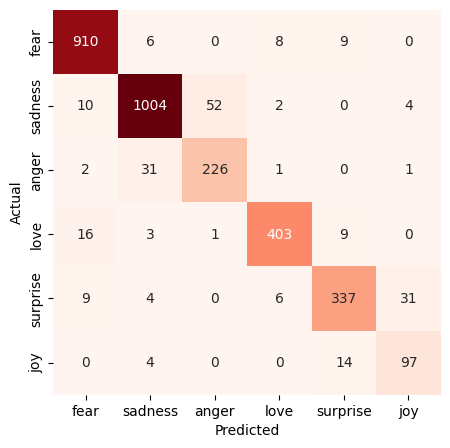

In [55]:
confusion_m = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_m, annot=True, xticklabels=label2id.keys(),yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Building Prediction Fuction and Store Model

In [56]:
text = "I'm super happy today, I have done alot of investigation and everything seemed to be work out well for me"

def get_prediction(text):
  input_encoded = tokenizer(text, return_tensors='pt').to(device)
  with torch.no_grad():
    outputs = model(**input_encoded)
  logits = outputs.logits
  pred = torch.argmax(logits, dim=1).item()
  return id2label[pred]
get_prediction(text)

'joy'

In [57]:
trainer.save_model("bert_base_uncased-sentiment-analysis-model-lusanda")

In [58]:
from transformers import pipeline
classifier = pipeline('text-classification', model='bert_base_uncased-sentiment-analysis-model-lusanda')
classifier(text)

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9925270080566406}]

In [59]:
import pandas as pd
import numpy as np
from transformers import pipeline
import ipywidgets as widgets
from IPython.display import display

print("Fine Tuning Bert for Twitter tweets for Multiclass classification")
classifier = pipeline('text-classification', model='bert_base_uncased-sentiment-analysis-model-lusanda')
text_area = widgets.Textarea(value='',placeholder='Enter some text data here',description='Text:',disabled=False)
button = widgets.Button(description="Predict")
output = widgets.Output()
def on_button_click(b):
    with output:
        output.clear_output()
        text = text_area.value
        if text:
            result = classifier(text)
            print(result)
        else:
            print("Please enter some text.")

button.on_click(on_button_click)
display(text_area, button, output)

Device set to use cuda:0


Fine Tuning Bert for Twitter tweets for Multiclass classification


Textarea(value='', description='Text:', placeholder='Enter some text data here')

Button(description='Predict', style=ButtonStyle())

Output()